<div>
<img src="https://discuss.pytorch.org/uploads/default/original/2X/3/35226d9fbc661ced1c5d17e374638389178c3176.png" width="400" style="margin: 50px auto; display: block; position: relative; left: -30px;" />
</div>

<!--NAVIGATION-->
# < [Autograd](2-Autograd.ipynb) | Optimization | [Modules](4-Modules.ipynb) >

### Optimization

In this short notebook, we will see how to use the gradient obtained with Autograd to perform optimization of an objective function.  
Then we will also present some off-the-shelf Pytorch optimizers and learning rate schedulers.  
As an eye candy, we will finish with some live optimization vizualisations.

### Table of Contents

#### 1. [Optimization](#Optimization)  
#### 2. [Live Plots](#Live-Plots)

___

In [11]:
import sys
import torch

# %matplotlib widget

# if 'google.colab' in sys.modules: # Execute if you're using Google Colab
#     !wget -q https://raw.githubusercontent.com/theevann/amld-pytorch-workshop/master/live_plot.py -O live_plot.py
#     !pip install -q ipympl

%matplotlib ipympl
torch.set_printoptions(precision=3)


---

# Optimization

## Optimizing "by hand"

We will start with a simple example : minimizing the square function.


In [12]:
def f(x):
    return x ** 2

We will minimize the function $f$ "by hand" using the gradient descent algorithm.

As a reminder, the update step of the algorithm is:
$$x_{t+1} = x_{t} - \lambda \nabla_x f (x_t)$$

Note:
- The gradient information $\nabla_x f (x)$ will be stored in `x.grad` once we run the `backward` function.
- The gradient is accumulated by default, so we need to clear `x.grad` after each iteration.
- We need to use `with torch.no_grad():` context for the update step since we want to change `x` in place but don't want autograd to track this change.

#### **Your turn !**

In [19]:
x0 = 8
lr = 0.02
iterations = 10

x = torch.Tensor([x0]).requires_grad_()
y = f(x)

for i in range(iterations):
    y = f(x)
    y.backward()
    with torch.no_grad():
        x -= lr * x.grad
    print("y.data = {}, x.grad = {}, x = {}".format(y.data,x.grad,x))
    x.grad.zero_()
    # print(y.data)

y.data = tensor([64.]), x.grad = tensor([16.]), x = tensor([7.680], requires_grad=True)
y.data = tensor([58.982]), x.grad = tensor([15.360]), x = tensor([7.373], requires_grad=True)
y.data = tensor([54.358]), x.grad = tensor([14.746]), x = tensor([7.078], requires_grad=True)
y.data = tensor([50.097]), x.grad = tensor([14.156]), x = tensor([6.795], requires_grad=True)
y.data = tensor([46.169]), x.grad = tensor([13.590]), x = tensor([6.523], requires_grad=True)
y.data = tensor([42.549]), x.grad = tensor([13.046]), x = tensor([6.262], requires_grad=True)
y.data = tensor([39.213]), x.grad = tensor([12.524]), x = tensor([6.012], requires_grad=True)
y.data = tensor([36.139]), x.grad = tensor([12.023]), x = tensor([5.771], requires_grad=True)
y.data = tensor([33.306]), x.grad = tensor([11.542]), x = tensor([5.540], requires_grad=True)
y.data = tensor([30.695]), x.grad = tensor([11.081]), x = tensor([5.319], requires_grad=True)


#### Why do we use `with torch.no_grad()` ?

Because `x` "requires grad", any operation we apply to `x` is recorded for automatic differentiation. As we don't want to track the update step of the parameters, we need to "tell" autograd not to track this change. This is done by using `torch.no_grad()`.

## Optimizing with an optimizer

### Different optimizers
PyTorch provides most common optimization algorithms encapsulated into "optimizer classes".  
An optimizer is an object that automatically loops through all the numerous parameters of your model and performs the (potentially complex) update step for you.

You first need to import `torch.optim`. 

In [20]:
import torch.optim as optim

Below are the most commonly used optimizers. Each of them has its specific parameters that you can check on the [Pytorch Doc](https://pytorch.org/docs/master/optim.html#algorithms).

In [21]:
parameters = [x]  # This should be the list of model parameters

optimizer = optim.SGD(parameters, lr=0.01, momentum=0.9)
optimizer = optim.Adam(parameters, lr=0.01)
optimizer = optim.Adadelta(parameters, lr=0.01)
optimizer = optim.Adagrad(parameters, lr=0.01)
optimizer = optim.RMSprop(parameters, lr=0.01)
optimizer = optim.LBFGS(parameters, lr=0.01)

# and there is more ...

### Using an optimizer

Now, let's use an optimizer to do the optimization !

You will need 2 new functions:
- `optimizer.zero_grad()` : This function sets the gradient of the parameters (`x` here) to 0 (otherwise it will get accumulated)
- `optimizer.step()` :  This function applies an update step

#### **Your turn !**

In [25]:
x0 = 8
lr = 0.01
iterations = 10

x = torch.Tensor([x0]).requires_grad_()  # 需要求导的变量
y = f(x)

# 定义优化器
parameters = [x] 
optimizer = torch.optim.Adam(parameters, lr=lr)  # 使用 adam 优化器

for i in range(iterations):
    y = f(x)  # 计算损失
    y.backward()  # 反向传播，计算梯度
    optimizer.step()  # 使用优化器更新参数
    optimizer.zero_grad()  # 清除之前的梯度
    print(y.data)  # 打印每次迭代的结果

tensor([64.])
tensor([63.840])
tensor([63.680])
tensor([63.521])
tensor([63.362])
tensor([63.203])
tensor([63.044])
tensor([62.885])
tensor([62.727])
tensor([62.569])


### Using a learning rate scheduler

In addition to an optimizer, a learning rate scheduler can be used to adjust the learning rate during training by reducing it according to a pre-defined schedule.  
Below are some of the schedulers available in PyTorch.

In [26]:
optim.lr_scheduler.LambdaLR
optim.lr_scheduler.ExponentialLR
optim.lr_scheduler.MultiStepLR
optim.lr_scheduler.StepLR

# and some more ...

torch.optim.lr_scheduler.StepLR

Let's try `optim.lr_scheduler.ExponentialLR`:

In [8]:
def f(x):
    return x.abs() * 5

In [9]:
x0 = 8
lr = 0.5
iterations = 150

x = torch.Tensor([x0]).requires_grad_()
optimizer = optim.SGD([x], lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.8)

for i in range(iterations):
    optimizer.zero_grad()
    y = f(x)
    y.backward()
    optimizer.step()
    scheduler.step()
    print(y.data, " | lr : ", optimizer.param_groups[0]['lr'])

tensor([40.])  | lr :  0.4
tensor([27.500])  | lr :  0.32000000000000006
tensor([17.500])  | lr :  0.25600000000000006
tensor([9.500])  | lr :  0.20480000000000007
tensor([3.100])  | lr :  0.16384000000000007
tensor([2.020])  | lr :  0.13107200000000005
tensor([2.076])  | lr :  0.10485760000000005
tensor([1.201])  | lr :  0.08388608000000004
tensor([1.421])  | lr :  0.06710886400000003
tensor([0.677])  | lr :  0.05368709120000003
tensor([1.001])  | lr :  0.042949672960000025
tensor([0.341])  | lr :  0.03435973836800002
tensor([0.733])  | lr :  0.027487790694400018
tensor([0.126])  | lr :  0.021990232555520017
tensor([0.561])  | lr :  0.017592186044416015
tensor([0.011])  | lr :  0.014073748835532814
tensor([0.429])  | lr :  0.011258999068426251
tensor([0.077])  | lr :  0.009007199254741001
tensor([0.205])  | lr :  0.007205759403792801
tensor([0.020])  | lr :  0.0057646075230342415
tensor([0.160])  | lr :  0.0046116860184273935
tensor([0.016])  | lr :  0.003689348814741915
tensor([0.100

In [27]:
import torch
import torch.optim as optim
import math

# 创建一个简单的模型（例如，线性模型）
model = torch.nn.Linear(10, 2)

# 创建优化器
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 定义一个学习率调整的 lambda 函数
# 使用正弦函数进行调整
lr_lambda = lambda epoch: 0.5 * (1 + math.sin(epoch / 10.0 * math.pi))

# 使用 LambdaLR 进行学习率调整
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 模拟训练过程
for epoch in range(20):
    # 每次更新模型（这里只是一个例子）
    optimizer.step()
    
    # 调用 scheduler.step() 来调整学习率
    scheduler.step()
    
    print(f"Epoch {epoch + 1}: Learning rate is {optimizer.param_groups[0]['lr']}")

Epoch 1: Learning rate is 0.06545084971874737
Epoch 2: Learning rate is 0.07938926261462366
Epoch 3: Learning rate is 0.09045084971874738
Epoch 4: Learning rate is 0.09755282581475769
Epoch 5: Learning rate is 0.1
Epoch 6: Learning rate is 0.09755282581475769
Epoch 7: Learning rate is 0.09045084971874738
Epoch 8: Learning rate is 0.07938926261462367
Epoch 9: Learning rate is 0.06545084971874737
Epoch 10: Learning rate is 0.05000000000000002
Epoch 11: Learning rate is 0.03454915028125262
Epoch 12: Learning rate is 0.02061073738537635
Epoch 13: Learning rate is 0.009549150281252633
Epoch 14: Learning rate is 0.0024471741852423235
Epoch 15: Learning rate is 0.0
Epoch 16: Learning rate is 0.002447174185242318
Epoch 17: Learning rate is 0.009549150281252623
Epoch 18: Learning rate is 0.020610737385376332
Epoch 19: Learning rate is 0.03454915028125262
Epoch 20: Learning rate is 0.04999999999999999


---

# Live Plots 

Below are some live plots to see what actually happens when you optimize a function.  
You can play with learning rates, optimizers and also define new functions to optimize !

_Note: These are not stricly speaking live plots as it is not possible to do so in colab. We actually create a video of the optimization process instead_

## 2D Plot - Optimization process

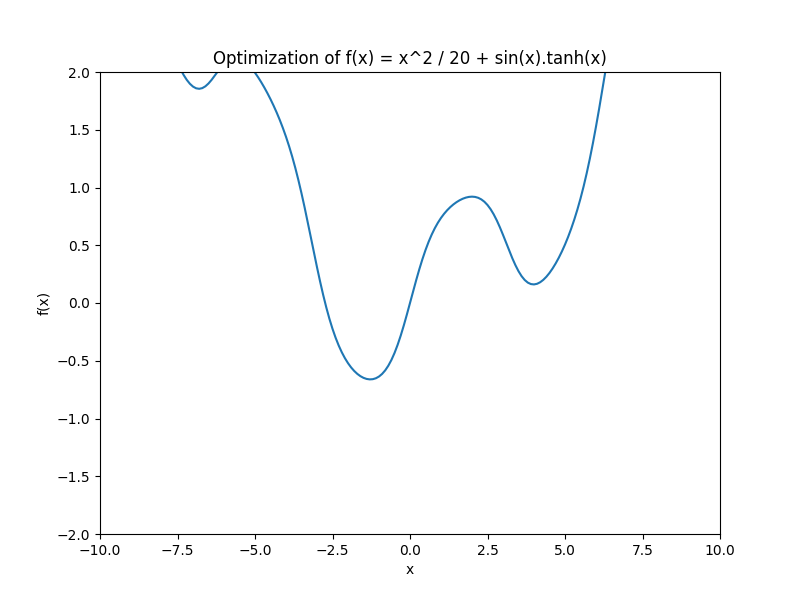

In [43]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 定义目标函数
def function_2d(x):
    return x ** 2 / 20 + x.sin().tanh()

# 定义 2D 动画绘制函数
def plot_2d(x_range, function, points, frames=400):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(-10, 10)
    ax.set_ylim(-2, 2)

    # 绘制目标函数的曲线
    ax.plot(x_range.numpy(), function(x_range).numpy(), label="f(x)")
    
    # 初始化动画中的散点
    scatter, = ax.plot([], [], 'ro')

    def update(frame):
        # 获取当前点的 x 和 f(x) 值
        x_value, f_value = points[frame]
        scatter.set_data(x_value, f_value)
        return scatter,

    # 创建动画
    ani = FuncAnimation(fig, update, frames=range(len(points)), interval=200, blit=True)

    # 显示图形
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Optimization of f(x) = x^2 / 20 + sin(x).tanh(x)")
    plt.show()

# 初始化参数
x0 = 8
lr = 0.2
iterations = 15
points = []

# 生成 x 范围用于绘图
x_range = torch.arange(-10, 10, 0.1)
x = torch.Tensor([x0]).requires_grad_()
optimizer = torch.optim.Adam([x], lr=lr)

# 执行优化过程
for i in range(iterations):
    optimizer.zero_grad()
    f = function_2d(x)
    f.backward()
    points.append((x.item(), f.item()))  # 保存 x 和 f(x) 的值
    optimizer.step()

# 绘制结果
plot_2d(x_range, function_2d, points)

# 关键点解释
# 目标函数：function_2d(x) 定义了一个数学函数，计算输入 x 对应的值。
# 优化过程：
# 初始化 x 为 x0，并启用梯度计算。
# 使用 torch.optim.Adam 优化器来更新 x 的值，优化目标是使 f(x) 最小化。
# 在每次迭代时，计算目标函数的值 f(x)，执行反向传播，并保存当前 x 和 f(x) 的值，以便绘制动画。
# 绘制动画：
# plot_2d 使用 matplotlib 来绘制目标函数，并通过 FuncAnimation 创建动画。动画更新时会显示每次迭代后 x 和 f(x) 的变化。
# 动画函数：FuncAnimation 创建动态更新的效果，每次更新时将优化过程中的 x 和 f(x) 更新到图中。
# 运行结果
# 动画显示 x 在 2D 图中的变化过程，并且动态更新 f(x)，使你能够看到随着优化过程的进行，x 如何收敛。
# 如果你运行代码并且系统中已安装了 matplotlib，你会看到优化过程的动画效果。
# 需要安装的库
# 如果尚未安装相关库，可以通过以下命令安装：
# 
# 
# pip install torch matplotlib
# 这样，你就能够在每次迭代后通过动画可视化 x 和 f(x) 的变化，并观察到优化过程的效果。


In [44]:
# from live_plot import anim_2d

In [45]:
# def function_2d(x):
#     return x ** 2 / 20 + x.sin().tanh()

In [46]:
# x0 = 8
# lr = 2
# iterations = 15
# points= []
# 
# x_range = torch.arange(-10, 10, 0.1)
# x = torch.Tensor([x0]).requires_grad_()
# optimizer = torch.optim.Adam([x], lr=lr)
# 
# for i in range(iterations):
#     optimizer.zero_grad()
#     f = function_2d(x)
#     f.backward()
#     points += [(x.item(), f.item())]
#     optimizer.step()
#     
# anim_2d(x_range, function_2d, points, 400)

## 3D Plot - Optimization process

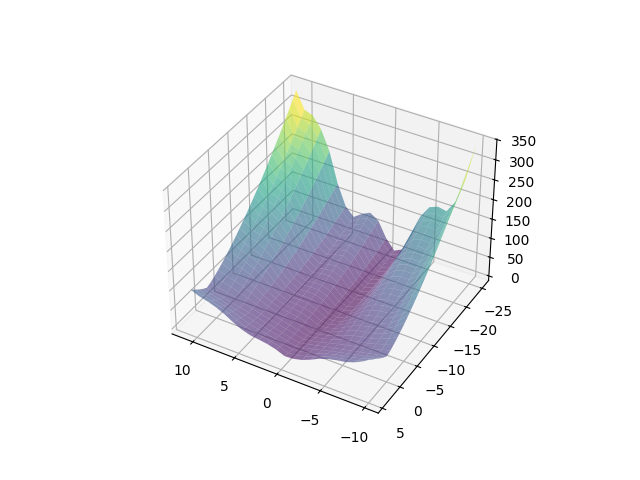

In [47]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 定义 3D 函数
def function_3d(x, y):
    return (x ** 2 / 20 + x.sin().tanh()) * (y.abs()) ** 1.2 + 5 * x.abs() + (y + 7)**2 / 10

# 初始化参数
elev, azim = 37, 120
x0, y0 = 6, -15
lr = 0.1
iterations = 15

# 定义优化器
x = torch.Tensor([x0]).requires_grad_()
y = torch.Tensor([y0]).requires_grad_()
optimizer = torch.optim.SGD([x, y], lr=lr)

points = []

# 优化过程
for i in range(iterations):
    optimizer.zero_grad()
    f = function_3d(x, y)
    f.backward()
    points.append((x.item(), y.item(), f.item()))
    optimizer.step()

# 3D 动画绘制
def anim_3d(x_range, y_range, elev, azim, function_3d, points, frames=100):
    # 创建 3D 图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 创建网格数据
    x_vals = x_range.numpy()
    y_vals = y_range.numpy()
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = function_3d(torch.tensor(X), torch.tensor(Y))

    # 绘制初始曲面
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)

    # 设置视角
    ax.view_init(elev=elev, azim=azim)

    # 初始化散点
    scatter, = ax.plot([], [], [], 'ro')

    # 动画更新函数
    def update(frame):
        x_val, y_val, z_val = points[frame]
        scatter.set_data(x_val, y_val)
        scatter.set_3d_properties(z_val)
        return scatter,

    # 创建动画
    ani = FuncAnimation(fig, update, frames=range(len(points)), interval=200, blit=True)

    # 显示图形
    plt.show()

# 生成 x 和 y 范围的张量
x_range = torch.arange(-10, 12, 1).float()
y_range = torch.arange(-25, 5, 1).float()

# 调用动画函数
anim_3d(x_range, y_range, elev, azim, function_3d, points)


# 代码解释
# function_3d(x, y)：这是你的目标函数，它接受 x 和 y 两个输入，并根据公式计算输出。
# 
# 优化过程：
# 
# x 和 y 初始化为 x0 和 y0，并启用 requires_grad=True 使得这些变量支持梯度计算。
# 使用 torch.optim.SGD 来优化这两个变量。
# 每次迭代时计算目标函数 f(x, y)，执行反向传播计算梯度，并更新 x 和 y 的值。
# 将每次迭代的 (x, y, f(x, y)) 保存到 points 列表中，以便用于动画绘制。
# anim_3d 函数：
# 
# FuncAnimation 用于创建 3D 动画，动态更新散点的位置，显示优化过程中的每一步。
# plot_surface 用来绘制目标函数的 3D 曲面，并通过 scatter 显示优化过程中 x 和 y 的位置。
# view_init 控制视角的 elev 和 azim 参数，用于设置 3D 图形的视角。
# 运行效果：
# 
# 通过动画可以看到随着优化的进行，x 和 y 的变化过程以及目标函数的变化。
# 运行时的注意事项
# 安装必要的库：确保安装了 torch 和 matplotlib，你可以通过以下命令来安装：
# 

# pip install torch matplotlib
# 动画效果：如果你使用 Jupyter Notebook，确保能显示图形。运行该代码时，图形将在弹出窗口中显示出来。
# 
# 性能优化：如果优化过程过慢，可以调整学习率和迭代次数，或减少绘制的点数。


In [48]:
# from live_plot import anim_3d

__Choose a function below and run the cell__

In [49]:
# elev, azim = 40, 250
# x0, y0 = 6, -0.01
# x_range = torch.arange(-10, 10, 1).float()
# y_range = torch.arange(-15, 10, 2).float()
# 
# def function_3d(x, y):
#     return x ** 2 - y ** 2

In [50]:
# elev, azim = 30, 130
# x0, y0 = 10, -4
# x_range = torch.arange(-10, 15, 1).float()
# y_range = torch.arange(-15, 10, 2).float()
# 
# def function_3d(x, y):
#     return x ** 3 - y ** 3

In [51]:
# elev, azim = 80, 130
# x0, y0 = 4, -5
# x_range = torch.arange(-10, 10, .5).float()
# y_range = torch.arange(-10, 10, 1).float()
# 
# def function_3d(x, y):
#     return (x ** 2 + y ** 2).sqrt().sin()

In [52]:
# elev, azim = 37, 120
# x0, y0 = 6, -15
# x_range = torch.arange(-10, 12, 1).float()
# y_range = torch.arange(-25, 5, 1).float()
# 
# # lr 0.15 momentum 0.5
# def function_3d(x, y):
#     return (x ** 2 / 20 + x.sin().tanh()) * (y.abs()) ** 1.2 + 5 * x.abs() + (y + 7)**2 / 10

__Optimize the function__

In [53]:
# lr = .1
# iterations = 15
# 
# x = torch.Tensor([x0]).requires_grad_()
# y = torch.Tensor([y0]).requires_grad_()
# optimizer = torch.optim.SGD([x, y], lr=lr)
# points = []
# 
# for i in range(iterations):
#     optimizer.zero_grad()
#     f = function_3d(x, y)
#     f.backward()
#     points += [(x.item(), y.item(), f.item())]
#     optimizer.step()
#     
# anim_3d(x_range, y_range, elev, azim, function_3d, points, 100)

___

<!--NAVIGATION-->
# < [Autograd](2-Autograd.ipynb) | Optimization | [Modules](4-Modules.ipynb) >